# NLP Basics Assessment

In [ ]:
# Importamos Librerias
import spacy
import re
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD


import matplotlib.pyplot as plt

from collections import Counter
nlp = spacy.load('en_core_web_sm')

**1. Creamos el documento desde el archivo**<br>


In [ ]:
# Descargamos el nuevo texto desde nuestro repositorio
!wget -O warofworlds.txt https://raw.githubusercontent.com/Can0land/NLP-Laboratory/refs/heads/main/warofworlds.txt


--2026-02-14 00:32:52--  https://raw.githubusercontent.com/Can0land/NLP-Laboratory/refs/heads/main/warofworlds.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32225 (31K) [text/plain]
Saving to: ‘warofworlds.txt’

warofworlds.txt     100%[===================>]  31.47K  --.-KB/s    in 0s      

2026-02-14 00:32:53 (119 MB/s) - ‘warofworlds.txt’ saved [32225/32225]



In [ ]:
# Creamos el documento NLP a partir del archivo descargado
with open('./warofworlds.txt', encoding='utf-8') as file:
    doc = nlp(file.read())

# observmos parte del documento
doc[:50]

I.
THE EVE OF THE WAR.
No one would have believed in the last years of the nineteenth century that this world was being watched keenly and closely by intelligences greater than man’s and yet as mortal as his own; that as men busied themselves

**2. EDA estructural del documento (global)**

In [ ]:
"""
En esta sección calculamos estadísticas descriptivas básicas del documento.
El objetivo es entender la magnitud y estructura general del texto antes de
realizar análisis más específicos.

Calculamos:
- Número total de caracteres
- Número total de tokens (sin contar espacios)
- Número de palabras alfabéticas
- Número total de oraciones

Esto nos permite tener una visión general del tamaño y complejidad del corpus.
"""

num_chars = len(doc.text)
num_tokens = len([t for t in doc if not t.is_space])
num_words = len([t for t in doc if t.is_alpha])
num_sents = len(list(doc.sents))

print("Chars:", num_chars)
print("Tokens (no espacios):", num_tokens)
print("Words (alpha):", num_words)
print("Sentences:", num_sents)
print("Promedio palabras por oración:", round(num_words/num_sents,2))


Chars: 32023
Tokens (no espacios): 6532
Words (alpha): 5720
Sentences: 292
Promedio palabras por oración: 19.59



- El documento contiene 32,023 caracteres y 5,720 palabras alfabéticas distribuidas en 292 oraciones.
- El promedio aproximado es de 19–20 palabras por oración, lo que sugiere una estructura narrativa relativamente estándar y no excesivamente compleja.



**2.1 Exploración dataset breve**

In [ ]:
# Exploramos una oración y para cada oración obtenemos su respectivo Text, POS, dep y lemma
sentences = list(doc.sents)
len(sentences)

print("{:20}{:20}{:20}{:20}".format("Text", "POS", "dep", "lemma"))
for token in sentences[3]:
    print(f"{token.text:{20}}{token.pos_:{20}}{token.dep_:{20}}{token.lemma_:{20}}")

Text                POS                 dep                 lemma               
It                  PRON                nsubj               it                  
is                  AUX                 ROOT                be                  
possible            ADJ                 acomp               possible            
that                SCONJ               mark                that                
the                 DET                 det                 the                 
infusoria           NOUN                nsubj               infusoria           
under               ADP                 prep                under               
the                 DET                 det                 the                 
microscope          NOUN                pobj                microscope          
do                  VERB                ccomp               do                  
the                 DET                 det                 the                 
same                ADJ     

In [ ]:
#  Implementamos un matcher llamado Planet que encuentre las ocurrencias de la frase planet mars bold text

from spacy.matcher import Matcher

matcher = Matcher(nlp.vocab)
pattern = [
    {'LOWER': 'planet'},
    {'LOWER': 'mars'}
]

matcher.add("PLANET_MARS", [pattern])

found_matches = matcher(doc)
found_matches



[(7415427269746771929, 260, 262), (7415427269746771929, 4538, 4540)]

In [ ]:
# Imprimimos el texto al rededor de cada match encontrado

start, end = found_matches[0][1:]
doc[start-9:end+13]

start, end = found_matches[1][1:]
doc[start-7:end+5]

that the Thing had come from the planet Mars, but I judged it

In [ ]:
# Imprimimos la oración que contiene cada match encontrado

for sentence in sentences:
    for _, start, end in found_matches:
        if sentence.start <= start and sentence.end >= end:
            print(sentence.text, '\n')

The planet Mars, I scarcely need remind the reader, revolves about the sun at a mean distance of 140,000,000 miles, and the light and heat it receives from the sun is barely half of that received by this world. 

At that time it was quite clear in my own mind that the Thing had come from the planet Mars, but I judged it improbable that it contained any living creature. 



**3. Construcción de dataset a nivel oración**

In [ ]:
"""
Convertimos el documento completo en un conjunto de oraciones.

Objetivo:
Transformar el texto en unidades analizables.
En PLN es común trabajar a nivel de oración o párrafo para:
-nalizar distribución de longitudes
- Aplicar modelos de clasificación A
- Calcular similitudes

Cada oración será una fila en nuestro DataFrame.
"""

sentences = [sent.text.strip() for sent in doc.sents if len(sent.text.strip()) > 0]
df = pd.DataFrame({"sentence": sentences})

# Calculamos métricas estructurales por oración
df["len_chars"] = df["sentence"].apply(len)
df["len_words"] = df["sentence"].apply(lambda x: len(x.split()))

display(df.head())
print("Total de oraciones:", len(df))


,sentence,len_chars,len_words
0,I.\nTHE EVE OF THE WAR.,22,6
1,No one would have believed in the last years o...,422,72
2,With infinite complacency men went to and fro ...,144,24
3,It is possible that the infusoria under the mi...,67,12
4,No one gave a thought to the older worlds of s...,169,33


Total de oraciones: 292


**4. Distribución de longitud de oraciones**

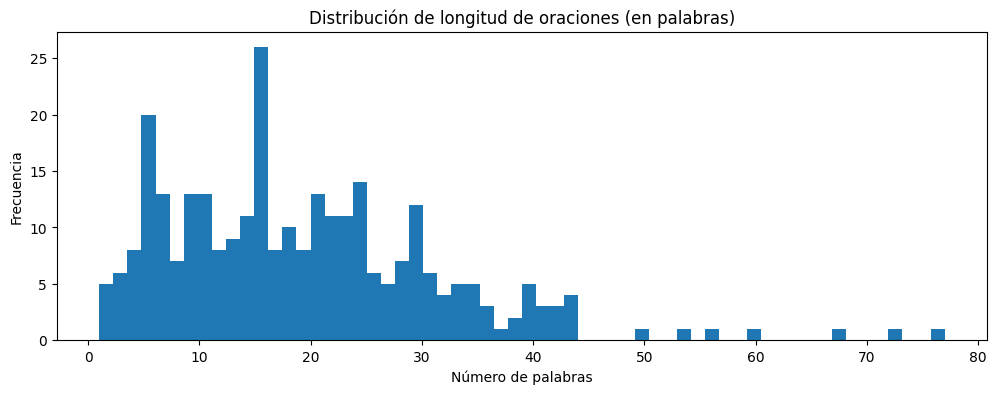

,sentence,len_chars,len_words
275,The peculiar V-shaped mouth with its pointed u...,496,77
1,No one would have believed in the last years o...,422,72
20,"And looking across space with instruments, and...",428,68
290,Anyone coming along the road from Chobham or W...,349,60
45,"In spite of all that has happened since, I sti...",334,56


In [ ]:
"""
Analizamos la distribución de la longitud de las oraciones en número de palabras.

Objetivo:
- Identificar si existen oraciones extremadamente largas o cortas.
- Entender la variabilidad estructural del texto.
- Detectar posibles outliers.
- Evaluar si sería necesario truncar en un modelo futuro.

La visualización ayuda a comprender la dispersión.
"""

plt.figure(figsize=(12,4))
plt.hist(df["len_words"], bins=60)
plt.title("Distribución de longitud de oraciones (en palabras)")
plt.xlabel("Número de palabras")
plt.ylabel("Frecuencia")
plt.show()

# Mostrar las oraciones más largas (posibles outliers)
df.sort_values("len_words", ascending=False).head(5)



- La distribución muestra que la mayoría de las oraciones se concentran
entre 5 y 30 palabras, con un pico aproximado entre 15 y 25 palabras.

- Se observa una asimetría positiva (cola derecha), indicando la presencia
de algunas oraciones significativamente más largas (hasta ~75 palabras),
lo cual sugiere estructuras sintácticas complejas.

- Este patrón es característico de narrativa literaria, donde predominan
oraciones de longitud media con ocasionales construcciones extensas y subordinadas.

- Desde una perspectiva de PLN, esta variabilidad puede influir en la
estabilidad de representaciones vectoriales y en la complejidad
sintáctica del análisis.


**5. Tokenización y lematización**

In [ ]:

"""
Aplicamos tokenización y lematización usando spaCy.

Procesos aplicados:
- Eliminación de stopwords
- Eliminación de signos de puntuación
- Eliminación de espacios
- Filtrado de tokens no alfabéticos
- Lematización

Objetivo:
Reducir variabilidad léxica y normalizar palabras para análisis de frecuencia.
Por ejemplo: "running", "runs", "ran" → "run"
"""

def sent_tokens(sent):
    d = nlp(sent) # Spicy tokeniza, asigna POS, Lematiza, identifica Stopwords, Aplica reglas lingüisticas
    tokens = [
        t.lemma_.lower() #Convierte cada palabra a su forma base, Reduce variabilidad morfológica
        for t in d
        if (not t.is_stop) # Elimina stopwords
        and (not t.is_punct) # Elimina puntuación
        and (not t.is_space) # Elimina espacios
        and (t.is_alpha) # Elimina números, símbolos, tokens mixtos
        and (len(t) > 2) # Longitud minima (elimina: "he", "it", "us")
    ]
    return tokens

df["tokens"] = df["sentence"].apply(sent_tokens)
df["tokens"].head()


,tokens
0,"[eve, war]"
1,"[believe, year, nineteenth, century, world, wa..."
2,"[infinite, complacency, man, go, fro, globe, l..."
3,"[possible, infusoria, microscope]"
4,"[give, thought, old, world, space, source, hum..."


**6. Frecuencia de palabras (análisis léxico)**

In [ ]:
"""
Calculamos la frecuencia de aparición de cada lema en el documento.

Objetivo:
- Identificar los conceptos más recurrentes.
- Detectar temas dominantes.
- Entender el campo semántico del texto.

Este análisis es base para:
- Topic modeling
- Clasificación
- Construcción de features
"""

all_tokens = [tok for row in df["tokens"] for tok in row] # Convierte lista de listas en una sola lista plana y junta todos los tokens del documento
freq = Counter(all_tokens) # Cuenta cuántas veces aparece cada lema

top20 = freq.most_common(20)
print("Top 20 palabras más frecuentes:")
print(top20)


Top 20 palabras más frecuentes:
[('man', 28), ('cylinder', 27), ('see', 25), ('pit', 25), ('little', 20), ('go', 19), ('mars', 17), ('come', 17), ('planet', 17), ('night', 17), ('people', 17), ('fall', 17), ('star', 15), ('ogilvy', 15), ('thing', 15), ('earth', 14), ('hear', 12), ('stand', 12), ('light', 11), ('crowd', 11)]


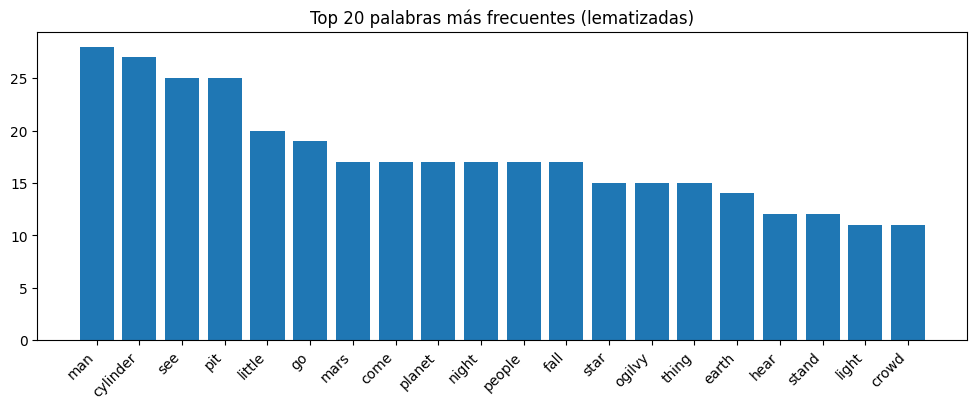

In [ ]:
# Visualización

words, counts = zip(*top20)

plt.figure(figsize=(12,4))
plt.bar(words, counts)
plt.xticks(rotation=45, ha="right")
plt.title("Top 20 palabras más frecuentes (lematizadas)")
plt.show()



- El análisis de frecuencia léxica revela que los términos más recurrentes
incluyen "man", "cylinder", "mars", "planet", "earth" y "people".

- Esto sugiere que el núcleo semántico del texto gira en torno a la relación
entre la humanidad y un evento asociado con Marte, reforzando el eje
narrativo de invasión y conflicto.

- La lematización permitió consolidar distintas formas morfológicas bajo
una raíz común, evitando fragmentación estadística y mejorando la
interpretación temática.

- Estos resultados constituyen la base para análisis posteriores como
modelado de temas o representaciones vectoriales.

**7. N-grams (contexto local)**

In [ ]:

"""
Los n-gramas permiten analizar combinaciones frecuentes de palabras consecutivas.

Objetivo:
- Capturar contexto local.
- Identificar expresiones recurrentes.
- Detectar patrones narrativos.

Bigramas → pares de palabras
Trigramas → ternas de palabras
"""

corpus = df["sentence"].tolist() # Convierte la columna sentence (que es una Serie de pandas) en una lista de strings.

def top_ngrams(corpus, ngram_range=(2,2), top_k=15):
    vec = CountVectorizer(ngram_range=ngram_range, min_df=3, stop_words="english") # Convierte texto en una matriz documento-término, Xij​=frecuencia del término j en documento i
    X = vec.fit_transform(corpus)  # fit aprende el vocabulario (extrae todos los n-gramas válidos) y transform construye la matriz documento-término (292 filas, N columnas de bigramas válidos) (Filas = documentos/oraciones, Columnnas = términos/n-gramas)
    freqs = np.asarray(X.sum(axis=0)).ravel() # Esto da la frecuencia total del n-grama en todo el corpus. Suma por columna
    idx = freqs.argsort()[::-1][:top_k] # Obtienes los índices de los n-gramas más frecuentes // argsort() → devuelve índices ordenados // [::-1] → invierte (de mayor a menor) // [:top_k] → toma los primeros k
    ngrams = np.array(vec.get_feature_names_out())[idx] # nombres reales de los n-gramas.
    counts = freqs[idx] # Extraes las frecuencias correspondientes
    return list(zip(ngrams, counts))

print("Top bigramas:")
print(top_ngrams(corpus, (2,2)))

print("\nTop trigramas:")
print(top_ngrams(corpus, (3,3)))


Top bigramas:
[('edge pit', np.int64(8)), ('sand pits', np.int64(5)), ('nineteenth century', np.int64(4)), ('railway station', np.int64(3)), ('pine trees', np.int64(3)), ('men mars', np.int64(3)), ('fallen pit', np.int64(3)), ('falling star', np.int64(3)), ('end cylinder', np.int64(3)), ('early morning', np.int64(3)), ('000 miles', np.int64(3)), ('000 000', np.int64(3))]

Top trigramas:
[('000 000 miles', np.int64(3))]


- El análisis de n-gramas permite identificar combinaciones frecuentes de palabras consecutivas, capturando contexto local dentro del texto.

- Entre los bigramas más frecuentes destacan "edge pit", "sand pits",
"nineteenth century", "falling star" y "railway station", lo que
sugiere escenarios físicos y referencias temporales relevantes
para la narrativa.

- La presencia de "000 miles" y "000 000 miles" indica patrones
numéricos asociados a descripciones de distancia, típicos de
narrativas científicas o astronómicas.


**8. Representación TF-IDF + Reducción Dimensional**

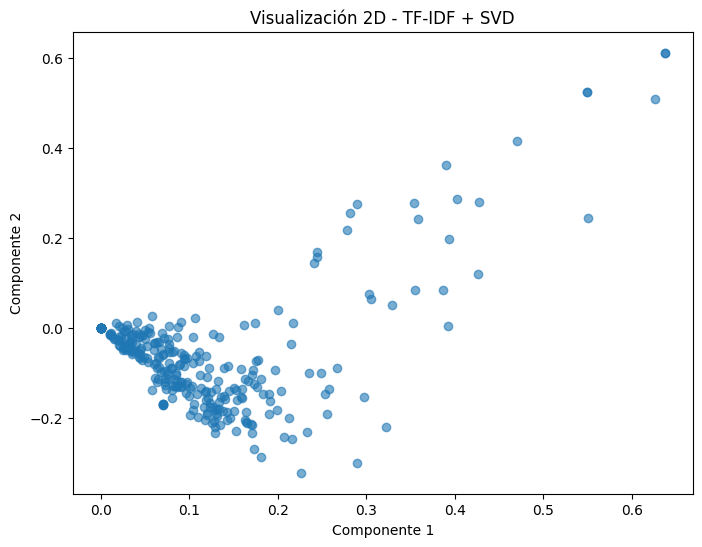

In [ ]:

"""
TF-IDF transforma el texto en una matriz numérica ponderada según la
importancia de cada término.

Luego aplicamos SVD (reducción dimensional) para proyectar las oraciones
en un espacio bidimensional.

Objetivo:
- Visualizar estructura latente del texto.
- Detectar agrupamientos temáticos.
- Explorar si existen clusters naturales.
"""

tfidf = TfidfVectorizer(max_features=5000, min_df=3, stop_words="english") #TF-IDF transforma cada oración en un vector donde TF → frecuencia del término en la oración y IDF → penaliza términos que aparecen en muchas oraciones.
X = tfidf.fit_transform(df["sentence"]) # Cada oracion se transforma en un punto en un espacio de miles de dimensiones.

svd = TruncatedSVD(n_components=2, random_state=42) # SVD (Single Value Decomposition) Proyección a un espacio latente de menor dimensión (n_components = 2 significa que se esta proyectando todo el espacio semántico a 2 dimensiones.)
X_2d = svd.fit_transform(X)

plt.figure(figsize=(8,6))
plt.scatter(X_2d[:,0], X_2d[:,1], alpha=0.6)
plt.title("Visualización 2D - TF-IDF + SVD")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.show()


- La visualización muestra una concentración principal de puntos y una
dispersión hacia la derecha, lo que sugiere la existencia de un núcleo
temático dominante junto con algunas oraciones semánticamente más
diferenciadas.

**9. Distribución de categorías gramaticales (POS)**

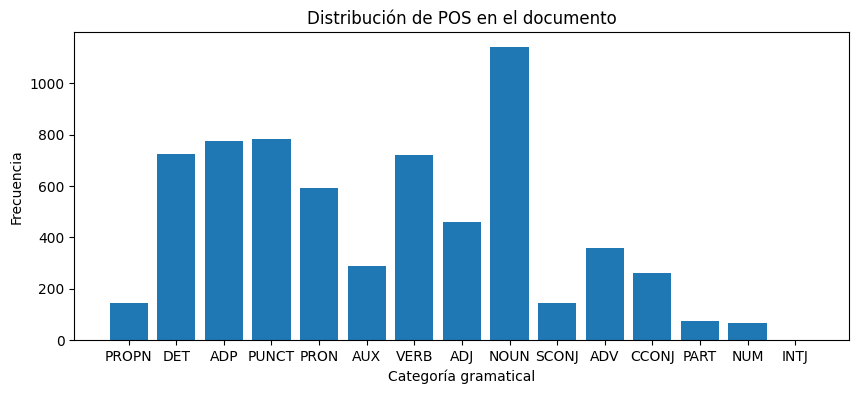

In [ ]:

"""
Analizamos la frecuencia de categorías gramaticales (sustantivos, verbos, adjetivos, etc.).

Objetivo:
- Entender el estilo lingüístico.
- Analizar predominancia narrativa.
- Identificar si el texto es más descriptivo (ADJ),
  más narrativo (VERB), o más conceptual (NOUN).
"""

pos_counts = Counter([t.pos_ for t in doc if not t.is_space])

labels = list(pos_counts.keys())
vals = list(pos_counts.values())

plt.figure(figsize=(10,4))
plt.bar(labels, vals)
plt.title("Distribución de POS en el documento")
plt.xlabel("Categoría gramatical")
plt.ylabel("Frecuencia")
plt.show()


- Se observa una predominancia de sustantivos (NOUN) y verbos (VERB),
lo que sugiere una narrativa centrada en acciones y entidades.

- La presencia significativa de adjetivos (ADJ) y adverbios (ADV)
indica un componente descriptivo relevante, característico de
narrativa literaria.

**10. Diversidad léxica (Type-Token Ratio)**

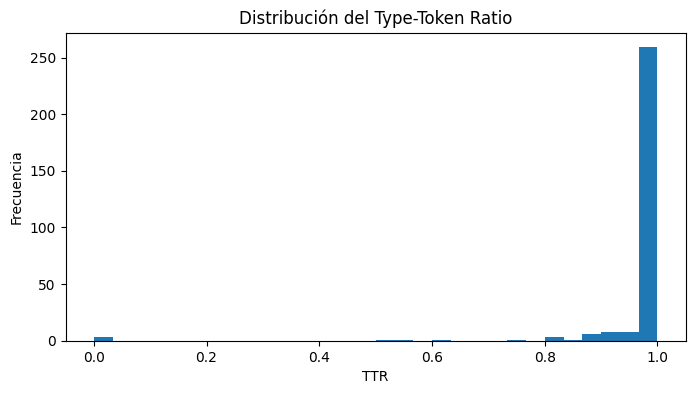

In [ ]:
"""
Calculamos el Type-Token Ratio (TTR).

TTR = (Número de palabras únicas) / (Número total de palabras)

Objetivo:
- Medir riqueza léxica.
- Evaluar complejidad lingüística.
- Comparar secciones del texto.

Valores cercanos a 1 → alta diversidad
Valores bajos → vocabulario repetitivo
"""

def type_token_ratio(tokens):
    if len(tokens) == 0:
        return 0
    return len(set(tokens)) / len(tokens)

df["ttr"] = df["tokens"].apply(type_token_ratio)

plt.figure(figsize=(8,4))
plt.hist(df["ttr"], bins=30)
plt.title("Distribución del Type-Token Ratio")
plt.xlabel("TTR")
plt.ylabel("Frecuencia")
plt.show()


- Se observa una fuerte concentración de valores cercanos a 1, lo que
indica que muchas oraciones contienen pocas repeticiones internas
de términos.

- Este comportamiento es consistente con textos narrativos, donde
las oraciones suelen introducir información nueva en lugar de
repetir términos dentro de la misma unidad.

- No obstante, el TTR calculado a nivel oración puede sobreestimar
la diversidad léxica debido a la corta longitud de las unidades
analizadas.